In [1]:
import pickle
with open("noniid_train.txt", "rb") as fp:
    (train_x, train_y) = pickle.load(fp)
with open("noniid_test.txt", "rb") as fp:
    (test_x, test_y) = pickle.load(fp)

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image

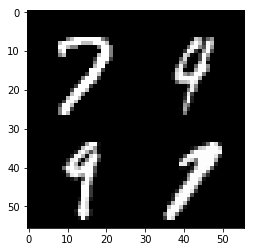

1


In [3]:
import random 
idx = random.randint(0,1000)
image = PIL.Image.fromarray(np.squeeze(train_x[idx]) )
plt.imshow(image)
plt.show()
print(train_y[idx])

In [4]:
class PVRDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = torch.tensor(X, dtype = torch.float)/255
        self.y = torch.tensor(y, dtype = torch.long)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
def gen_mask():
    masks = []
    m = torch.ones(28,28)
    for x in range(2):
        for y in range(2):
            mask = torch.zeros(1,56,56)
            mask[0, x*28:(x+1)*28, y*28:(y+1)*28] = m
            masks.append(mask)
    return torch.cat(masks).unsqueeze(0)
masks = gen_mask()
print(masks.shape)    

torch.Size([1, 4, 56, 56])


In [6]:
trainset = PVRDataset(train_x, train_y)
testset = PVRDataset(test_x, test_y)

In [7]:
train_loader = DataLoader(trainset, batch_size=64, shuffle=True,num_workers=1)
test_loader = DataLoader(testset, batch_size=64, shuffle=False,num_workers=1)

In [16]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 8, 3, 1)

        self.fc1 = nn.Linear(1352, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        output = F.softmax(x, dim = 1)#gumbel_softmax(x, tau=1, hard=False, dim = 1)
        return output
actor = Actor()

In [17]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 8, 3, 1)

        self.fc1 = nn.Linear(1352, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
critic = Critic()

In [18]:
def train(gen, dis, train_loader, optimizer, epoch):
    gen.train()
    dis.train()
    running_loss = 0.0
    correct = 0.0
    acc = []
    
    n = len(train_loader.dataset)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data, target
        optimizer.zero_grad()
        mask_val = gen(data)
        mask_val = mask_val.unsqueeze(-1).unsqueeze(-1)
        data_mask = mask_val * masks.repeat(len(target),1,1,1)
        data = torch.sum(data * data_mask, dim = 1, keepdim = True)
        
        output = dis(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    
    print('Loss/train:', running_loss/n, 'Accuracy/train:', correct/n)
    return correct/n

In [19]:
def test(gen, dis, test_loader, epoch):
    gen.eval()
    dis.eval()
    test_loss = 0
    correct = 0
    n = len(test_loader.dataset)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data, target
            mask_val = gen(data)
            mask_val = mask_val.unsqueeze(-1).unsqueeze(-1)
            data_mask = mask_val * masks.repeat(len(target),1,1,1)
            data = torch.sum(data * data_mask, dim = 1, keepdim = True)

            output = dis(data)
            
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()


    print('Loss/test:', test_loss/n, 'Accuracy/test:', correct/n)
    return correct/n

In [20]:
acc_train = []
acc_test = []
optimizer = optim.Adam(list(actor.parameters())+list(critic.parameters()), lr=1e-3)
for epoch in range(1, 10):
    acc_train.append(train(actor, critic, train_loader, optimizer, epoch))
    acc_test.append(test(actor, critic, test_loader, epoch))

Loss/train: 0.023450900039076805 Accuracy/train: 0.4979
Loss/test: 4.210068084716797 Accuracy/test: 0.013
Loss/train: 0.009819104650616646 Accuracy/train: 0.8181
Loss/test: 5.19206120300293 Accuracy/test: 0.019
Loss/train: 0.006642575757205486 Accuracy/train: 0.8815
Loss/test: 4.858455368041993 Accuracy/test: 0.01
Loss/train: 0.004627690044790507 Accuracy/train: 0.9148
Loss/test: 5.498603881835938 Accuracy/test: 0.012
Loss/train: 0.003629465948417783 Accuracy/train: 0.9324
Loss/test: 5.922451766967773 Accuracy/test: 0.005
Loss/train: 0.002904480972699821 Accuracy/train: 0.9449
Loss/test: 6.087490753173828 Accuracy/test: 0.006
Loss/train: 0.002148308204859495 Accuracy/train: 0.9602
Loss/test: 7.230091400146485 Accuracy/test: 0.005
Loss/train: 0.0016227727896533906 Accuracy/train: 0.9685
Loss/test: 7.586256652832032 Accuracy/test: 0.01
Loss/train: 0.0015182521053589881 Accuracy/train: 0.9698
Loss/test: 7.203475341796875 Accuracy/test: 0.01


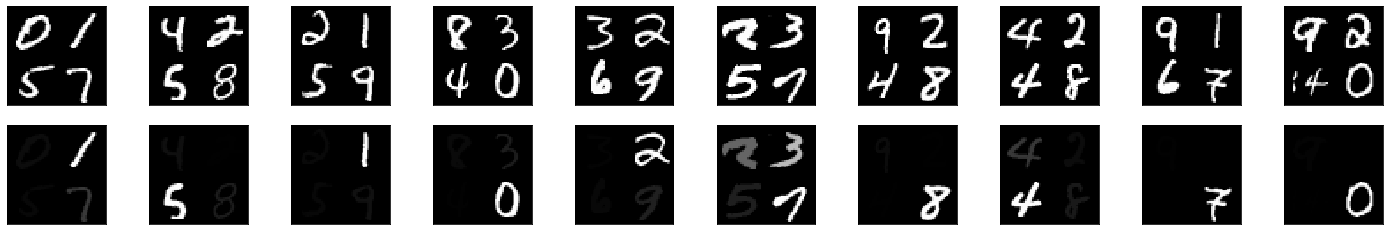

In [21]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

mask_val = actor(images)
mask_val = mask_val.unsqueeze(-1).unsqueeze(-1)
data_mask = mask_val * masks.repeat(64,1,1,1)
data = torch.sum(images * data_mask, dim = 1, keepdim = True)
images = images.numpy()
masked_images = data.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for images, row in zip([images, masked_images], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)